# Vision Transformer 的实现


在本笔记中，我们将实现 **Vision Transformer（ViT）** 并使用小型数据集 **CIFAR-10** 进行测试。该实现基于笔记本 2 "GptFromScratch" 的部分内容，因此需要按顺序完成相关步骤。

我们参考论文 [《An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale》](https://arxiv.org/pdf/2010.11929)。

下图是该论文中的关键示意图，我们将逐步实现：

![ViT](./images/ViT.png)


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
import torchvision.datasets as datasets
import matplotlib.pyplot as plt

# Detection automatique du GPU
device = "cpu"
if torch.cuda.is_available():
    device = "cuda"
print(f"using device: {device}")

using device: cpu


## 复用之前的代码


首先，我们将复用[本课程笔记本 2「GptFromScratch」](../07_Transformers/02_GptFromScratch.ipynb)中的代码，并进行适当修改。


### 自注意力层


在笔记本 2 中，我们实现了 **masked multi-head attention** 层，用于训练 **decoder** 类型的 Transformer。而对于图像处理，我们需要 **encoder** 类型的 Transformer，因此需要调整实现。

修改过程很简单：在 **decoder** 中，我们使用下三角矩阵相乘来「掩盖」未来信息。但在 **encoder** 中，我们不需要掩盖未来信息，因此只需移除该矩阵相乘操作即可。

调整后的 Python 代码如下：


In [2]:
class Head_enc(nn.Module):
    """ Couche de self-attention unique """

    def __init__(self, head_size,n_embd,dropout=0.2):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B,T,C = x.shape
        k = self.key(x)   # (B,T,C)
        q = self.query(x) # (B,T,C)
        # Le * C**-0.5 correspond à la normalisation par la racine de head_size
        wei = q @ k.transpose(-2,-1) * C**-0.5 # (B, T, C) @ (B, C, T) -> (B, T, T)
        # On a supprimer le masquage du futur
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        v = self.value(x) # (B,T,C)
        out = wei @ v # (B, T, T) @ (B, T, C) -> (B, T, C)
        return out

### 多头自注意力层


为了实现多头注意力，我们将复用笔记本 2 中的类，但使用 **Head_enc** 替代 **Head**：


In [3]:
class MultiHeadAttention(nn.Module):
    """ Plusieurs couches de self attention en parallèle"""

    def __init__(self, num_heads, head_size,n_embd,dropout):
        super().__init__()
        # Création de num_head couches head_enc de taille head_size
        self.heads = nn.ModuleList([Head_enc(head_size,n_embd,dropout) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

### 前馈神经网络层


我们将复用之前实现的 **feed forward layer**，仅将激活函数由 **ReLU** 改为 **GeLU**（如论文所述）：


In [4]:
class FeedFoward(nn.Module):

    def __init__(self, n_embd,dropout):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.GELU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

### Transformer 编码器块


最后，我们将构建与上图对应的 **Transformer 编码器块**：


In [5]:
class TransformerBlock(nn.Module):
    """ Block transformer"""

    def __init__(self, n_embd, n_head,dropout=0.):
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size,n_embd,dropout)
        self.ffwd = FeedFoward(n_embd,dropout)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

**注**：此处对这些层的介绍较为简略，因为笔记本 2 中已详细实现。如有疑问，请参阅笔记本 2。


## 网络实现


现在，我们将逐步实现该网络。


### 将图像分割为补丁


论文中描述的第一步是将图像分割为 **补丁（patch）**：

每张图像被分割为 $N$ 个大小为 $p \times p$ 的补丁，然后将补丁展平（flatten）。图像维度从 $\mathbf{x} \in \mathbb{R}^{H \times W \times C}$ 转换为补丁序列 $\mathbf{x}_p \in \mathbb{R}^{N \times (P^2 \cdot C)}$。

![patchs](./images/patchs.png)


为了实现这一点，我们将从 **CIFAR-10** 数据集中提取一张图像作为示例，以验证代码是否正常运行。


In [6]:
transform=T.ToTensor() # Pour convertir les éléments en tensor torch directement
dataset = datasets.CIFAR10(root='./../data', train=True, download=True,transform=transform)

Files already downloaded and verified


我们提取该数据集中的一张图像进行测试：


torch.Size([3, 32, 32])


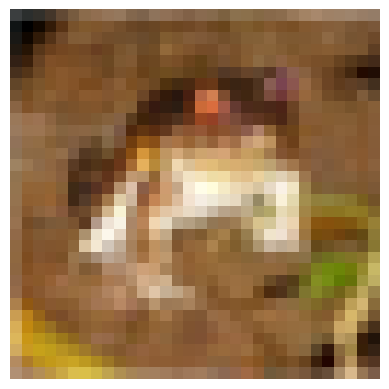

In [7]:
image=dataset[0][0]
print(image.shape)
plt.imshow(dataset[0][0].permute(1,2,0).numpy())
plt.axis("off")
plt.show()

一只漂亮的青蛙！

选择补丁的尺寸时，需确保其边长是 32 的倍数。例如，我们选择 $8 \times 8$，这样将得到 16 个补丁。我们将该值设为可调参数。

初步想法是通过两层循环（遍历宽度和高度）逐个提取补丁，例如：


In [8]:
patch_size = 8
list_of_patches = []
for i in range(0,image.shape[1],patch_size):
    for j in range(0,image.shape[2],patch_size):
        patch=image[:,i:i+patch_size,j:j+patch_size]
        list_of_patches.append(patch)
tensor_patches = torch.stack(list_of_patches)
print(tensor_patches.shape)

torch.Size([16, 3, 8, 8])


这种方法在代码效率上并不理想。在 PyTorch 中，我们可以使用 **view()** 和 **unfold()** 更高效地实现。这一步稍显复杂，但为了确保内存连续性（使 **view()** 正常工作），这是必要的。直接使用 ```patches = image.view(-1, C, patch_size, patch_size)``` 无法正常运行（可自行尝试验证）。


In [9]:
C,H,W = image.shape
# On utilise la fonction unfold pour découper l'image en patch contigus
# Le premier unfold découpe la première dimension (H) en ligne
# Le deuxième unfold découpe chacune des lignes en patch_size colonnes 
# Ce qui donne une image de taille (C, H//patch_size, W//patch_size,patch_size, patch_size)
patches = image.unfold(1, patch_size, patch_size).unfold(2, patch_size, patch_size)
# Permute pour avoir les dimensions dans le bon ordre
patches = patches.permute(1, 2, 0, 3, 4).contiguous()
patches = patches.view(-1, C, patch_size, patch_size)
print(patches.shape)
# On peut vérifier que ça fait bien la même chose
print((patches==tensor_patches).all())

torch.Size([16, 3, 8, 8])
tensor(True)


接下来，我们将展平补丁，以得到最终结果。


In [10]:
nb_patches = patches.shape[0]
print(nb_patches)
patches_flat = patches.flatten(1, 3)
print(patches_flat.shape)

16
torch.Size([16, 192])


我们定义一个函数来执行这些转换：


In [11]:
# La fonction a été modifiée pour prendre en compte le batch
def image_to_patches(image, patch_size):
    # On rajoute une dimension pour le batch
    B,C,_,_ = image.shape
    patches = image.unfold(2, patch_size, patch_size).unfold(3, patch_size, patch_size)
    patches = patches.permute(0,2, 3, 1, 4, 5).contiguous()
    patches = patches.view(B,-1, C, patch_size, patch_size)
    patches_flat = patches.flatten(2, 4)
    return patches_flat


大功告成！第一步已完成 :)


### 补丁的线性投影


现在进入第二步：将补丁线性投影到潜在空间。

![linearproj](./images/linearproj.png)


这一步相当于使用 **embedding 表** 将 **token** 转换为向量。此处，我们将展平的补丁转换为固定维度的向量，以便 Transformer 处理。我们定义 **embedding 维度** 和 **投影层**：


In [12]:
n_embd = 64
proj_layer = nn.Linear(C*patch_size*patch_size, n_embd)

这一步并不复杂，至此完成。


### 位置嵌入与类别 token


在进入已实现的 **Transformer 层** 之前，我们需要完成最后一步。

该步骤实际上包含两个子步骤：
- **添加位置嵌入**：与 GPT 类似，Transformer 无法自动感知补丁在图像中的位置。因此，我们添加专用的 **位置嵌入**，使网络能够理解补丁的相对位置关系。
- **添加类别 token**：这一步是全新的，因 GPT 中并不需要。该想法源自 [BERT](https://arxiv.org/pdf/1810.04805)，是一种在不固定序列长度的情况下使用 Transformer 进行分类的技术。若不添加 **类别 token**，我们要么需要在 Transformer 的所有输出上连接一个全连接网络（这要求固定序列长度），要么随机选择一个输出（对应一个补丁）连接全连接网络（但如何无偏地选择补丁？）。**类别 token** 通过添加一个专用于分类的 token 解决了这一问题。

**注**：在 CNN 中，可通过 **全局平均池化（global average pooling）** 避免输入维度固定的问题（输出尺寸固定的池化层）。该技术也可用于 Vision Transformer，以替代类别 token。

![embedclass](./images/embedclass.png)


In [13]:
# Pour le positional encoding, +1 pour le cls token
pos_emb = nn.Embedding(nb_patches+1, n_embd)
# On ajoute un token cls
cls_token = torch.zeros(1, 1, n_embd)
# On ajoutera ce token cls au début de chaque séquence

### 分类全连接网络


现在，我们进入 ViT 的最后一步：分类 **MLP 网络**。如果理解了 **类别 token** 的作用，就会知道该分类网络仅以该 token 作为输入，输出预测的类别。

![fcn](./images/fcn.png)

这一步的实现同样简单。论文中提到，训练时使用一个隐藏层网络，而微调（fine-tuning）时仅使用一层（详见课程 10）。为简化起见，我们使用单层线性层，将输出的 **类别 token** 投影到类别数量的维度。


In [14]:
classi_head = nn.Linear(n_embd, 10)

现在，我们已准备好所有组件，可以构建并训练 ViT 了！


### 构建 ViT 模型


现在，我们可以将所有组件组合起来，构建我们的 **Vision Transformer**。


In [15]:
class ViT(nn.Module):
    def __init__(self, n_embed,patch_size,C,n_head,n_layer,nb_patches,dropout=0.) -> None:
        super().__init__()
        self.proj_layer = nn.Linear(C*patch_size*patch_size, n_embed)
        self.pos_emb = nn.Embedding(nb_patches+1, n_embed)
        # Permet de créer cls_token comme un paramètre du réseau
        self.register_parameter(name='cls_token', param=torch.nn.Parameter(torch.zeros(1, 1, n_embed)))
        self.transformer=nn.Sequential(*[TransformerBlock(n_embed, n_head,dropout) for _ in range(n_layer)])
        self.classi_head = nn.Linear(n_embed, 10)
    
    def forward(self,x):
        B,_,_,_=x.shape
        # On découpe l'image en patch et on les applatit
        x = image_to_patches(x, patch_size)
        # On projette dans la dimension n_embed
        x = self.proj_layer(x)
        # On ajoute le token cls
        cls_tokens = self.cls_token.expand(B, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        # On ajoute le positional encoding
        pos_emb = self.pos_emb(torch.arange(x.shape[1], device=x.device))
        x = x + pos_emb
        # On applique les blocks transformer
        x = self.transformer(x)
        # On récupère le token cls
        cls_tokens = x[:, 0]
        # On applique la dernière couche de classification
        x = self.classi_head(cls_tokens)
        return x        

## 训练我们的 ViT


我们将在 **CIFAR-10** 数据集上训练 ViT 模型。**注**：我们定义的参数（如 *n_embed* 和 *patch_size*）适用于小尺寸图像。处理更大图像时，需调整这些参数。代码支持不同尺寸的图像，前提是图像尺寸可被补丁尺寸整除。


### 加载数据集：训练集、验证集与测试集


我们加载 **CIFAR-10** 数据集，并创建 **dataloader**：

**注**：可选择数据集的子集以加速训练。


In [16]:
classes = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')
# Transformation des données, normalisation et transformation en tensor pytorch
transform = T.Compose([T.ToTensor(),T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Téléchargement et chargement du dataset
dataset = datasets.CIFAR10(root='./../data', train=True,download=True, transform=transform)
testdataset = datasets.CIFAR10(root='./../data', train=False,download=True, transform=transform)
print("taille d'une image : ",dataset[0][0].shape)


#Création des dataloaders pour le train, validation et test
train_dataset, val_dataset=torch.utils.data.random_split(dataset, [0.8,0.2])
print("taille du train dataset : ",len(train_dataset))
print("taille du val dataset : ",len(val_dataset))
print("taille du test dataset : ",len(testdataset))
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16,shuffle=True, num_workers=2)
val_loader= torch.utils.data.DataLoader(val_dataset, batch_size=16,shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(testdataset, batch_size=16,shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified
taille d'une image :  torch.Size([3, 32, 32])
taille du train dataset :  40000
taille du val dataset :  10000
taille du test dataset :  10000


### 超参数与模型创建


现在，我们定义训练的 **超参数** 及模型的具体配置：


In [17]:
patch_size = 8
nb_patches = (32//patch_size)**2
n_embed = 64
n_head = 4
n_layer = 4
epochs = 10
C=3 # Nombre de canaux
lr = 1e-3
model = ViT(n_embed,patch_size,C,n_head,n_layer,nb_patches).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

### 模型训练


现在，终于可以开始训练模型了！


In [18]:
for epoch in range(epochs):
    model.train()
    loss_train = 0
    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        output = model(images)
        loss = F.cross_entropy(output, labels)
        loss_train += loss.item()
        loss.backward()
        optimizer.step()
        
    model.eval()
    correct = 0
    total = 0
    loss_val = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss_val += F.cross_entropy(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f"Epoch {epoch}, loss train {loss_train/len(train_loader)}, loss val {loss_val/len(val_loader)},précision {100 * correct / total}")

Epoch 0, loss train 1.6522698682546615, loss val 1.4414834783554078,précision 47.97
Epoch 1, loss train 1.3831321718215943, loss val 1.3656272639274598,précision 50.69
Epoch 2, loss train 1.271412028503418, loss val 1.2726070711135864,précision 55.17
Epoch 3, loss train 1.1935315937042237, loss val 1.2526390438556672,précision 55.52
Epoch 4, loss train 1.1144725002408027, loss val 1.2377954412460328,précision 55.66
Epoch 5, loss train 1.0520227519154548, loss val 1.2067877051830291,précision 56.82
Epoch 6, loss train 0.9839000009179115, loss val 1.2402711957931518,précision 56.93
Epoch 7, loss train 0.9204218792438507, loss val 1.2170260044574737,précision 58.23
Epoch 8, loss train 0.853291154640913, loss val 1.2737546770095824,précision 57.65
Epoch 9, loss train 0.7962572723925113, loss val 1.2941821083545684,précision 58.26


训练顺利完成，验证集准确率达 **58%**。现在，我们查看测试集上的结果：


In [19]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Précision {100 * correct / total}")

Précision 58.49


测试集上的准确率与验证集相当！

**注 1**：该结果看似一般，但请注意我们使用的是小型 Transformer，且训练轮次较少。可通过调整超参数来尝试提升性能。

**注 2**：论文作者指出，与 CNN 不同，Transformer 在图像上没有「归纳偏置（inductive bias）」，这源于其架构差异。CNN 的各层具有平移不变性，并捕捉每个像素的局部邻域信息；而 Transformer 主要利用全局信息。实践中，对于小型数据集（如 100 万张图像以下），CNN 表现更佳；但在大规模数据上，Transformer 更具优势。